In [21]:
import pandas as pd
import numpy as np
from datetime import datetime
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import signal

In [22]:
df = pd.read_csv('dataset1.csv') # import the dataset
df.head()

,Date,Value
0,2023-09-12,0.319383
1,2023-09-13,0.373839
2,2023-09-14,0.447583
3,2023-09-15,-0.252889
4,2023-09-16,-0.468198


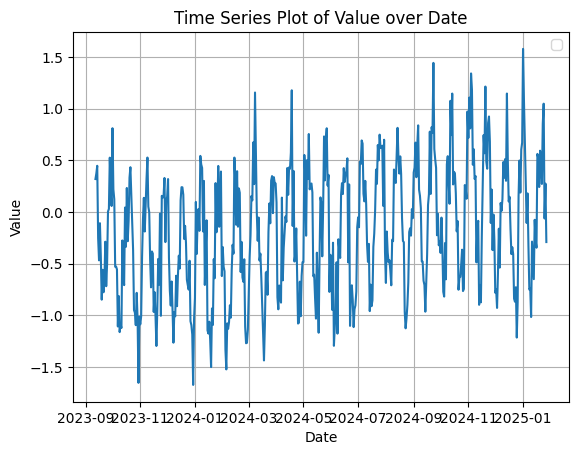

In [23]:
# plot the dataset for visual inspection

plt.plot(pd.to_datetime(df["Date"]), df["Value"])
plt.title('Time Series Plot of Value over Date')
plt.xlabel('Date')
plt.ylabel('Value')
plt.grid(True)
plt.legend()
plt.show()

data = np.array(df['Value'])

[252.          21.          19.38461538 504.          20.16      ]
[  2.61117712   3.38335498   8.28257953  17.48823287 107.32268162]


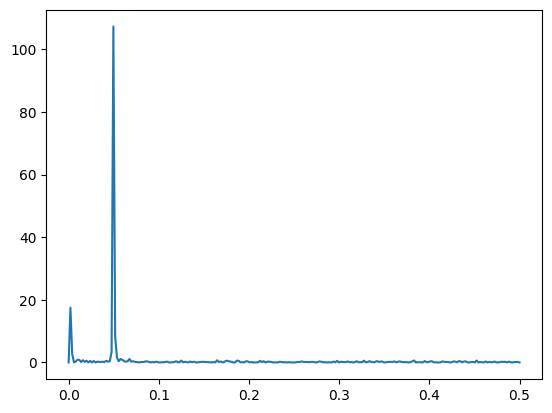

In [24]:
frequencies, power_spectrum = signal.periodogram(data, fs=1) # generate the periodogram
plt.plot(frequencies, power_spectrum) # plot the periodogram
# get the index of the five largest elements of power_spectrum to get the frequency
print(1/frequencies[np.argsort(power_spectrum)[-5:]])
print(np.sort(power_spectrum)[-5:])

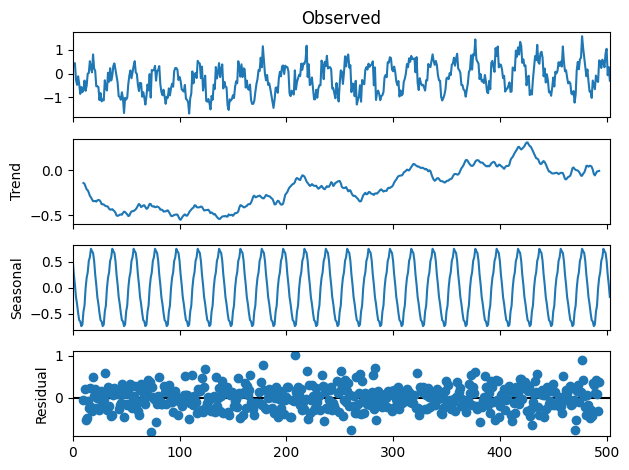

In [25]:
period = 20 # peak is clearly at 0.05, which corresponds to a period of 20 = 1/0.05

result_season_trend = seasonal_decompose(data, model='additive', period=period) # decomposition is additive (seasonality doesn't change with level of data)
result_season_trend.plot() # show the seasonal decomposition
plt.show()

In [26]:
# long-term forecast based on seasonality

current_date = datetime.strptime(df['Date'].iloc[-1], '%Y-%m-%d')
target_date = "2025-02-23"
target_date = datetime.strptime(target_date, '%Y-%m-%d')
delta = target_date - current_date # number of days from today to 23/02/2025
print(delta.days)
current_cycle_stage = len(data) % period # identify at what stage of the seasonality cycle we are currently. this is given by the index of the last data point modulo the period
print(current_cycle_stage)
target_cycle_stage = (current_cycle_stage + delta.days) % period # identify at what stage of the cycle will the target date be. this is given by the sum of the current cycle stage and the number of days to the target date modulo the period
print(target_cycle_stage)
print(result_season_trend.seasonal[target_cycle_stage] + np.mean(result_season_trend.observed - result_season_trend.seasonal)) # take the mean of the deseasonalised data (observed - seasonal) as the long-term trend is known to be 0, and then add the seasonal component at the target date to get the forecasted value

27
4
11
-0.5279394423667718


### Answer 1: Seasonal forecast for 23/02/2025 is negative

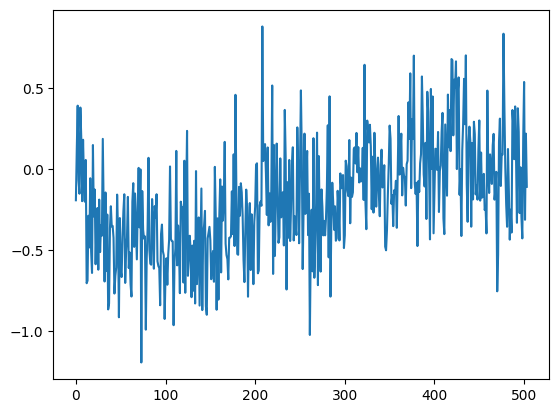

In [27]:
residuals = result_season_trend.observed - result_season_trend.seasonal # deseasonalise the data

residuals = residuals[~np.isnan(residuals)] # make sure there's no NaN in the residuals
plt.plot(residuals)

In [28]:
# apply adf test to residuals
from statsmodels.tsa.stattools import adfuller
result = adfuller(residuals)
# print a summary of the test
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1]) # check that the residuals are stationary


ADF Statistic: -2.308245
p-value: 0.169322


ADF Statistic: -11.801601
p-value: 0.000000


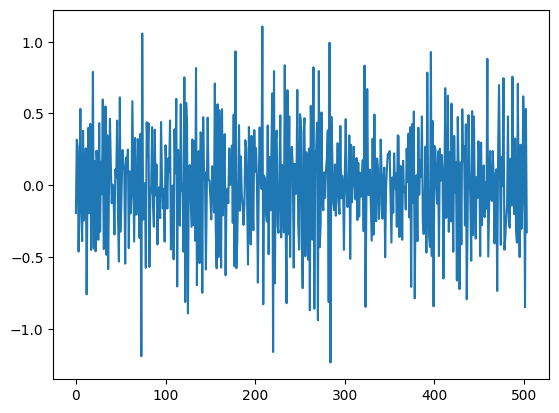

In [29]:
# take first differences
stat_residuals = np.diff(residuals, prepend=0) # residuals are not stationary (p > 0.05) so take first differences. prepending a 0 so that length of time series is the same

result = adfuller(stat_residuals)
# print a summary of the test
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1]) # re-check that the differenced residuals are stationary (they are)
plt.plot(stat_residuals)

In [30]:
import warnings

# identify the optimal arima model via the akaike criterion
def identify_best_arma_model(data, max_p, max_q):
    """
    Identifies the best ARMA(p, q) model using the AIC criterion.

    Parameters:
    - data: array-like, the time series data.
    - max_p: int, maximum AR order to consider.
    - max_q: int, maximum MA order to consider.

    Returns:
    - dict: Information about the best model including p, q, and AIC.
    """
    warnings.filterwarnings("ignore")  # Suppress warnings for non-converging models
    best_aic = np.inf
    best_order = None
    best_model = None

    for p in range(max_p + 1):
        for q in range(max_q + 1):
            try:
                model = ARIMA(data, order=(p, 0, q)).fit()
                if model.aic < best_aic:
                    best_aic = model.aic
                    best_order = (p, q)
                    best_model = model
            except Exception:
                continue

    return {
        "best_p": best_order[0],
        "best_q": best_order[1],
        "best_aic": best_aic,
        "model": best_model
    }

In [31]:
aic_result = identify_best_arma_model(stat_residuals, 5, 5)
print(aic_result)
model = aic_result['model']
print(model.summary()) # AIC gives ARMA(0,1), ie a MA(1) model. This is the model that was actually used to generate the data!

{'best_p': 0, 'best_q': 1, 'best_aic': np.float64(193.0785797151004), 'model': <statsmodels.tsa.arima.model.ARIMAResultsWrapper object at 0x758bda4535f0>}
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  504
Model:                 ARIMA(0, 0, 1)   Log Likelihood                 -93.539
Date:                Thu, 30 Jan 2025   AIC                            193.079
Time:                        16:23:58   BIC                            205.746
Sample:                             0   HQIC                           198.048
                                - 504                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.001      0.172      0.864 

In [32]:
forecast = model.get_forecast(steps=4) # forecasting 4-steps ahead, but only the first matters. however this shows the mean-reversion property of the MA(1): after the 1-step ahead forecast, all others are the unconditional mean c0 (or "const" in the model output)
forecast.summary_frame()

y,mean,mean_se,mean_ci_lower,mean_ci_upper
0,0.115494,0.290797,-0.454458,0.685447
1,0.000202,0.393547,-0.771135,0.771540
2,0.000202,0.393547,-0.771135,0.771540
3,0.000202,0.393547,-0.771135,0.771540


In [33]:
cycle_index = len(stat_residuals) % period # identify at what stage of the seasonality cycle we are currently. this is given by the index of the last data point modulo the period
print(cycle_index)

4


In [34]:
forecast_mean = residuals[-1] + result_season_trend.seasonal[cycle_index+1] + forecast.summary_frame()["mean"].iloc[0] # add the 1-step ahead forecasted value to the seasonal component at the next stage of the cycle to get the 1-step ahead forecasted value of the original log-price series
forecast_err = forecast.summary_frame()["mean_se"].iloc[0] # error is the same, as every other part of the above formula is deterministic


In [35]:
forecast_mean, forecast_err

(np.float64(-0.48190163266992414), np.float64(0.2907973784439611))

In [36]:
# Defining the functions calculating the probability that each bet is realised. The probability is that of a Normal random variable with mean equal to the forecast, and variance equal to the variance of the white noises (i.e. sigma^2).
# Since the payoff is 1, this is also equivalent to the expected payoff of the bet. If this is larger than the price paid for the bet, then the bet is profitable.
from scipy.stats import norm

def up_bet(forecast, K, sigma):
    return 1 - norm.cdf(K, forecast, sigma)

def down_bet(forecast, K, sigma):
    return norm.cdf(K, forecast, sigma)

def range_bet(forecast, K_low, K_high, sigma):
    return down_bet(forecast, K_high, sigma) * up_bet(forecast, K_low, sigma)

def out_range_bet(forecast, K_low, K_high, sigma):
    return 1 - range_bet(forecast, K_low, K_high, sigma)

In [37]:
price_up = 0.16
price_down = 0.84
price_range = 0.77
price_out = 0.23

print(f"Expected payoff of UP bet: {up_bet(forecast_mean, data[-1], forecast_err) - price_up:.3f}")
print(f"Expected payoff of DOWN bet: {down_bet(forecast_mean, data[-1], forecast_err) - price_down:.3f}")
print(f"Expected payoff of RANGE bet: {range_bet(forecast_mean, -0.49, -0.29, forecast_err) - price_range:.3f}")
print(f"Expected payoff of OUT bet: {out_range_bet(forecast_mean, -0.49, -0.29, forecast_err) - price_out:.3f}")

Expected payoff of UP bet: 0.096
Expected payoff of DOWN bet: -0.096
Expected payoff of RANGE bet: -0.389
Expected payoff of OUT bet: 0.389


In [38]:
# these are the probabilities of each bet without subtracting the price

print(up_bet(forecast_mean, data[-1], forecast_err))
print(down_bet(forecast_mean, data[-1], forecast_err))
print(range_bet(forecast_mean, -0.49, -0.29, forecast_err))
print(out_range_bet(forecast_mean, -0.49, -0.29, forecast_err))

0.25591515467502
0.74408484532498
0.3809527298201896
0.6190472701798104
